In [ ]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import matplotlib.pyplot as plt
%matplotlib inline

# Функции 

In [ ]:
def model_report(y_actual, y_predicted, name):
    print("--  Модель: ", name)
    print(f"Accuracy (score) = {accuracy_score(y_actual, y_predicted):.5f}")
    print(f"Precision = {precision_score(y_actual, y_predicted):.5f}")
    print(f"Recall = {recall_score(y_actual, y_predicted):.5f}")
    print(f"F1 Score = {f1_score(y_actual, y_predicted):.5f}")

In [ ]:
def plot_roc(y_actual, y_pred_proba):
    y_pred_proba = y_pred_proba[:, 1]
    fpr, tpr, thresholds = roc_curve(y_actual, y_pred_proba)
    roc_auc = roc_auc_score(y_actual, y_pred_proba)
    
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
    plt.title('Receiver Operating Characteristic', fontsize=15)
    plt.xlabel('False positive rate (FPR)', fontsize=15)
    plt.ylabel('True positive rate (TPR)', fontsize=15)
    
    #Оптимальная точка: где TPR максимален, а FPR минимален
    ix = np.argmax(np.sqrt(tpr * (1-fpr)))
    
    plt.plot(fpr[ix], tpr[ix], marker='o', color='black', label='Ортимальный порог')
    plt.legend(fontsize=15)

# Анализ

In [ ]:
df = pd.read_csv('adult.csv', delimiter=',')
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [ ]:
# Есть ли пропуски
print(df.isnull().sum())

age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64


Как интересно - пропусков нет, а в описании датасета сказано, что пропущены данные в полях workclass, occupation, native-country

In [ ]:
df.workclass.value_counts()

Private             33906
Self-emp-not-inc     3862
Local-gov            3136
?                    2799
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: workclass, dtype: int64

In [ ]:
# пропуски заменены на "?". Еще раз проверим на пропуски:
df[df=='?'].count()

age                   0
workclass          2799
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation         2809
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country      857
income                0
dtype: int64

Пропусков слишком много - оставлю значения "?" как отдельный класс

In [ ]:
# По каждому признаку - число уникальных значений и тип
for i in df.keys():
  print(f'{i} | {len(df[i].value_counts())} | {df[i].dtype}')

age | 74 | int64
workclass | 9 | object
fnlwgt | 28523 | int64
education | 16 | object
educational-num | 16 | int64
marital-status | 7 | object
occupation | 15 | object
relationship | 6 | object
race | 5 | object
gender | 2 | object
capital-gain | 123 | int64
capital-loss | 99 | int64
hours-per-week | 96 | int64
native-country | 42 | object
income | 2 | object


In [ ]:
# Что за данные в целевой переменной
df.income.value_counts()

<=50K    37155
>50K     11687
Name: income, dtype: int64

In [ ]:
# Меняем на числовые значения 0 и 1
df.income = df.income.map({'<=50K': 0, '>50K': 1}, )


# Построение модели

In [ ]:
# Для данных выбираем все числовые характеристики
y = df['income']
X = df[df.columns[df.dtypes!='object']].drop(columns='income')

In [ ]:
# обучаем две модели
model1 = LogisticRegression()
model2 = SVC()
model1.fit(X,y)
model2.fit(X,y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
# выводим значения точности
model_report(y, model1.predict(X), 'LogisticRegression')
model_report(y, model2.predict(X), 'SVC')

--  Модель:  LogisticRegression
Accuracy (score) = 0.79788
Precision = 0.71318
Recall = 0.25978
F1 Score = 0.38083
--  Модель:  SVC
Accuracy (score) = 0.79919
Precision = 0.95540
Recall = 0.16865
F1 Score = 0.28669


# Улучшение модели

In [ ]:
# Категориальные признаки превращаем в фиктивные, кроме native-country - отбросим, т.к. много категорий
df = pd.get_dummies(df, columns=['workclass', 'education', 'marital-status', 
                                       'occupation', 'relationship', 'race', 'gender'])

In [ ]:
X = df.drop(columns=['income','native-country'])
X.head()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,marital-status_Divorced,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_?,occupation_Adm-clerical,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,gender_Female,gender_Male
0,25,226802,7,0,0,40,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1
1,38,89814,9,0,0,50,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1
2,28,336951,12,0,0,40,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1
3,44,160323,10,7688,0,40,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
4,18,103497,10,0,0,30,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0


In [ ]:
# Второе обучение - с закодированными категориальными признаками
model1.fit(X,y)
model2.fit(X,y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
model_report(y, model1.predict(X), 'LogisticRegression')
model_report(y, model2.predict(X), 'SVC')

--  Модель:  LogisticRegression
Accuracy (score) = 0.79794
Precision = 0.71348
Recall = 0.25995
F1 Score = 0.38106
--  Модель:  SVC
Accuracy (score) = 0.79905
Precision = 0.95570
Recall = 0.16796
F1 Score = 0.28571


Точность Логистической регрессии увеличилась, Метода опорных векторов - немного упала.

Теперь сделаем стандартизацию/шкалирование признаков:

In [ ]:
# Шкалирование
X.loc[:,:] = preprocessing.StandardScaler().fit_transform(X)
X.head()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,marital-status_Divorced,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_?,occupation_Adm-clerical,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,gender_Female,gender_Male
0,-0.995129,0.351675,-1.197259,-0.144804,-0.217127,-0.034087,-0.246558,-0.173795,-0.261940,-0.01431,0.663711,-0.189609,-0.293019,-0.205606,-0.02074,-0.171088,5.094580,-0.116769,-0.071294,-0.102621,-0.141219,-0.125387,-0.184093,-0.209896,-0.443406,-0.110957,-0.690988,-0.239853,-0.041258,-0.131803,-0.535289,-0.396417,-0.027534,-0.919604,-0.114128,1.424944,-0.179829,-0.1791,-0.247025,-0.360265,-0.017527,-0.378203,-0.377283,-0.177388,-0.21048,3.893860,-0.334803,-0.070565,-0.380322,-0.143316,-0.356373,-0.174668,-0.225076,-0.822752,-0.589093,-0.178368,2.332956,-0.342391,-0.223869,-0.098572,-0.179161,3.070047,-0.091554,-2.428701,-0.70422,0.70422
1,-0.046942,-0.945524,-0.419335,-0.144804,-0.217127,0.772930,-0.246558,-0.173795,-0.261940,-0.01431,0.663711,-0.189609,-0.293019,-0.205606,-0.02074,-0.171088,-0.196287,-0.116769,-0.071294,-0.102621,-0.141219,-0.125387,-0.184093,-0.209896,-0.443406,-0.110957,1.447204,-0.239853,-0.041258,-0.131803,-0.535289,-0.396417,-0.027534,1.087425,-0.114128,-0.701782,-0.179829,-0.1791,-0.247025,-0.360265,-0.017527,-0.378203,-0.377283,5.637363,-0.21048,-0.256815,-0.334803,-0.070565,-0.380322,-0.143316,-0.356373,-0.174668,-0.225076,1.215433,-0.589093,-0.178368,-0.428641,-0.342391,-0.223869,-0.098572,-0.179161,-0.325728,-0.091554,0.411743,-0.70422,0.70422
2,-0.776316,1.394723,0.747550,-0.144804,-0.217127,-0.034087,-0.246558,-0.173795,3.817672,-0.01431,-1.506680,-0.189609,-0.293019,-0.205606,-0.02074,-0.171088,-0.196287,-0.116769,-0.071294,-0.102621,-0.141219,-0.125387,5.432051,-0.209896,-0.443406,-0.110957,-0.690988,-0.239853,-0.041258,-0.131803,-0.535289,-0.396417,-0.027534,1.087425,-0.114128,-0.701782,-0.179829,-0.1791,-0.247025,-0.360265,-0.017527,-0.378203,-0.377283,-0.177388,-0.21048,-0.256815,-0.334803,-0.070565,-0.380322,6.977584,-0.356373,-0.174668,-0.225076,1.215433,-0.589093,-0.178368,-0.428641,-0.342391,-0.223869,-0.098572,-0.179161,-0.325728,-0.091554,0.411743,-0.70422,0.70422
3,0.390683,-0.277844,-0.030373,0.886874,-0.217127,-0.034087,-0.246558,-0.173795,-0.261940,-0.01431,0.663711,-0.189609,-0.293019,-0.205606,-0.02074,-0.171088,-0.196287,-0.116769,-0.071294,-0.102621,-0.141219,-0.125387,-0.184093,-0.209896,-0.443406,-0.110957,-0.690988,-0.239853,-0.041258,-0.131803,1.868149,-0.396417,-0.027534,1.087425,-0.114128,-0.701782,-0.179829,-0.1791,-0.247025,-0.360265,-0.017527,-0.378203,-0.377283,-0.177388,-0.21048,3.893860,-0.334803,-0.070565,-0.380322,-0.143316,-0.356373,-0.174668,-0.225076,1.215433,-0.589093,-0.178368,-0.428641,-0.342391,-0.223869,-0.098572,-0.179161,3.070047,-0.091554,-2.428701,-0.70422,0.70422
4,-1.505691,-0.815954,-0.030373,-0.14480

In [ ]:
# Третье обучение - со стандартизованными значениями
model1 = LogisticRegression()
model2 = SVC(probability= True)
model1.fit(X,y)
model2.fit(X,y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
model_report(y, model1.predict(X), 'LogisticRegression')
model_report(y, model2.predict(X), 'SVC')

--  Модель:  LogisticRegression
Accuracy (score) = 0.85228
Precision = 0.73433
Recall = 0.59956
F1 Score = 0.66013
--  Модель:  SVC
Accuracy (score) = 0.86288
Precision = 0.76436
Recall = 0.61727
F1 Score = 0.68298


In [ ]:
# Посмотрим, как распределяются ошибки и точность определения y в двух моделях:
confusion_matrix(y, model1.predict(X))

array([[34620,  2535],
       [ 4680,  7007]])

In [ ]:
confusion_matrix(y, model2.predict(X))

array([[34931,  2224],
       [ 4473,  7214]])

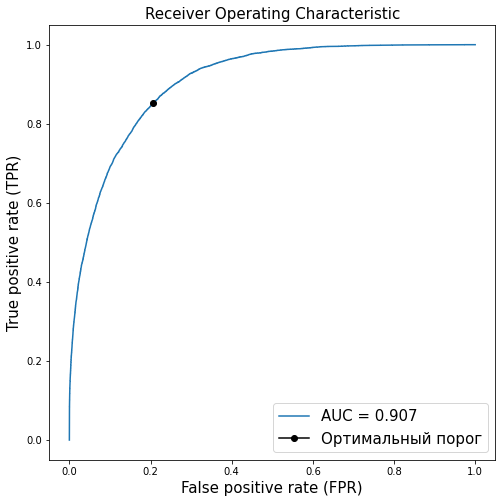

In [ ]:
# Наконец - построим ROC-кривую для каждой модели:
plot_roc(y, model1.predict_proba(X))

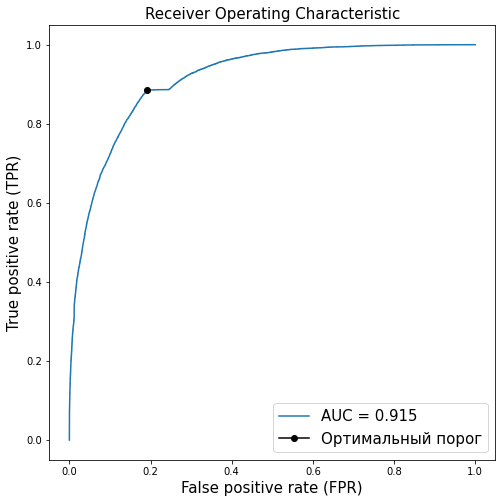

In [ ]:
plot_roc(y, model2.predict_proba(X))

# Лучшие параметры

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


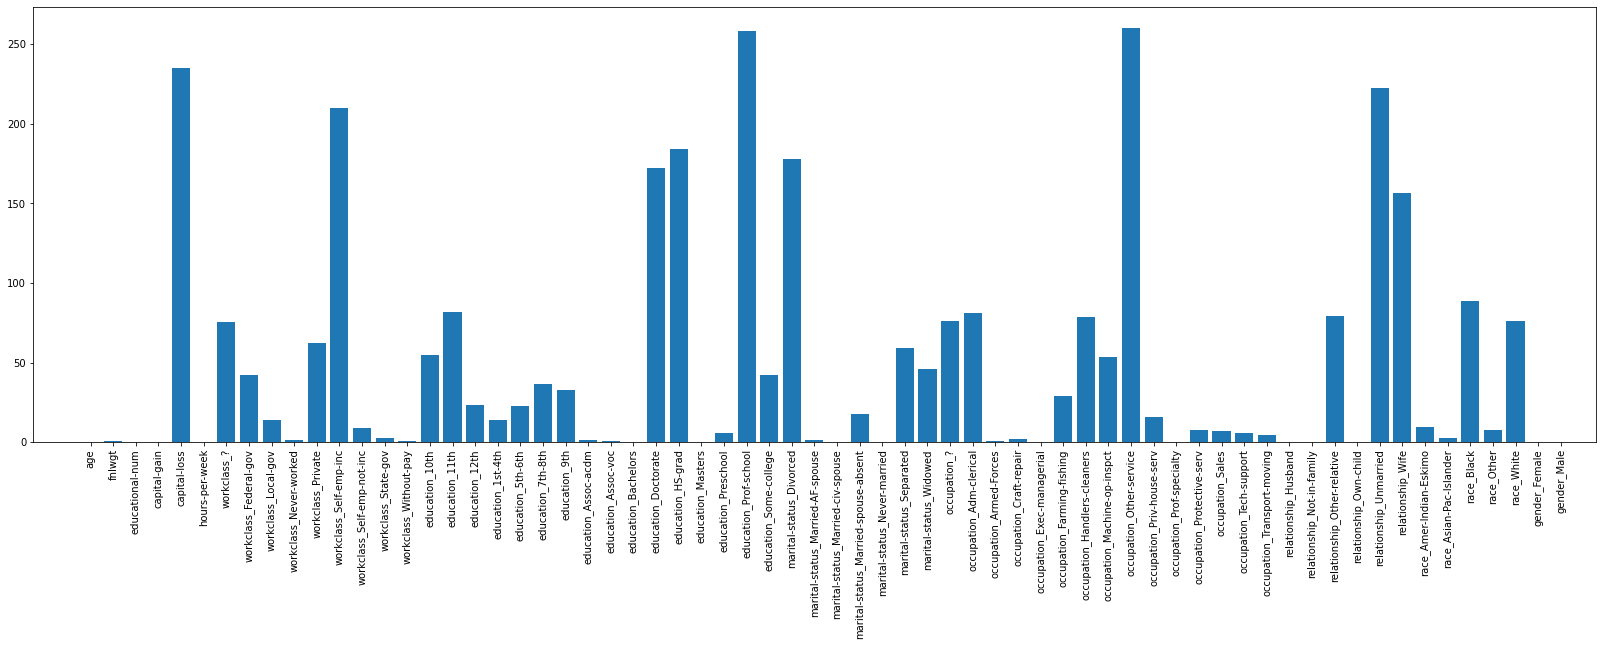

In [ ]:
selector = SelectKBest(k=10)
selector.fit(X, y)

scores = -np.log10(selector.pvalues_)
predictors = X.columns
plt.figure(figsize=(28, 8))
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()